In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

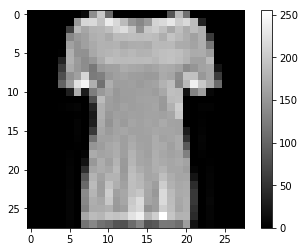

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

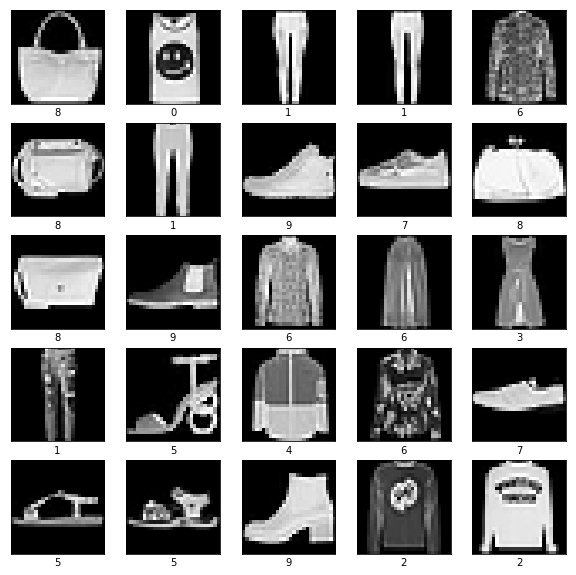

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i+100],cmap='gray')
    plt.xlabel(train_labels[i+100])
plt.show()


# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

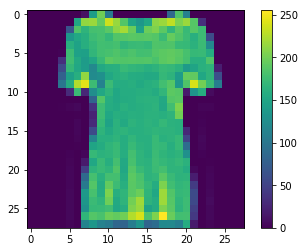

In [7]:
#60000 training
#10000 test
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

#imagenes Numpy Arrays de 28x28
#pixeles estan entre los valores de 0 a 255

np.shape(train_images)
#(60000,28,28)

train_images[11].shape
#train_images[11,1]    Fila 11 de 28, primer columna de 28 posibles
#shape = 28*28
train_labels.shape
#(60000,)
#Obteniendo los valores unicos de train_labels. De los 60000 imagenes, 
#hay n posibles resultados, cada etiqueta representa un tipo de prenda.
plt.imshow(train_images[10])
plt.colorbar()
 
np.unique(train_labels)
#vemos que hay de 0 a 9, es decir 10 tipos de prenda

#0 T-shirt/top
#1 Trouser
#2 Pullover
#3 Dress
#4 Coat
#5 Sandal
#6 Shirt
#7 Sneaker
#8 Bag
#9 Ankle boo

In [8]:
#1. Escoger 3 clases, filtrar y asignar en los arreglos labels e images
trlbls = np.isin(train_labels,[3,4,5])
trimgs = train_images[trlbls]
trlbls = train_labels[trlbls]

In [9]:
trimgs.shape
#18000 record saved, from 3 values = Dress[3], Coat[4] and Sandal[5]

tslbls = np.isin(test_labels,[3,4,5])
tsimgs = test_images[tslbls]
tslbls = test_labels[tslbls]
tsimgs.shape

(3000, 28, 28)

In [68]:
#2. Crear diccionario con el valor numérico de las labels y el texto correspondiente para poder 
#relacionar el valor numérico con el valor descriptivo/textual.
dCloth = {'0':'Dress','1':'Coat','2':'Sandal'}

#Using trlbls, trimgs, tsimgs, tslbls
#OneHotEncoding for labels in training and test set
trlblso = to_categorical(trlbls)[:,3:]
tslblso = to_categorical(tslbls)[:,3:]


In [71]:
print(dCloth.get('0'))

Dress


In [98]:
#Defining function

def RLog(xtr,xts,ytr,yts,norm=True,lr=0.01, epochs=20, batch=32, pickindex=0, rand5=False):
    if norm == True:
        #Flattening the images and normalizing
        xtr = xtr.reshape(len(xtr[:]),len(xtr[0])*len(xtr[0]))/255
        xts = xts.reshape(len(xts[:]),len(xts[0])*len(xts[0]))/255
    else:
        #Flattening the images to a vector - Keeping values as they came (0 to 255)
        xtr = xtr.reshape(len(xtr[:]),len(xtr[0])*len(xtr[0]))
        xts = xts.reshape(len(xts[:]),len(xts[0])*len(xts[0]))
    
    #Hyper parameters can be modified when the function is called. 
    #Defining batches
    batches = int(xtr.shape[0]/batch)
    tf.reset_default_graph()
    gr = tf.Graph()
    with gr.as_default():    
        #input data
        X = tf.placeholder(tf.float32, [None, 784])
        Y = tf.placeholder(tf.float32, [None, 3])
        #trainable parameters
        W = tf.Variable(0.1*np.random.rand(784,3).astype(np.float32))
        B = tf.Variable(0.1*np.random.rand(3).astype(np.float32))
        
        #Graph
        #PRediction function
        
        with tf.name_scope("Hyp"):
            pred = tf.nn.softmax(tf.add(tf.matmul(X,W, name="HypXbyW"),B, name="HypplusB"),name="ApplySoft")
        
        with tf.name_scope("Cost"):
            cost = tf.reduce_mean(-tf.reduce_sum(Y*tf.log(pred,name='logPred'),axis=1,name='SumLogs'), name='MeanCost')
        
        with tf.name_scope("Accuracy"):
                predcheck = tf.equal(tf.argmax(pred, 1), tf.argmax(Y, 1))
                accuracy = tf.reduce_mean(tf.cast(predcheck, tf.float32))
            
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
        
        with tf.Session(graph=gr) as ses:
            writer = tf.summary.FileWriter('./LogReg', ses.graph)
            ses.run(tf.global_variables_initializer())
            
            for epoch in range(epochs):
                for i in range(batches):
                    offset = i*epoch
                    x = xtr[offset: offset + batch]
                    y = ytr[offset: offset + batch]
                    ses.run(optimizer,feed_dict= {X:x,Y:y})
                    p, c, w, b = ses.run([pred,cost, W, B],feed_dict= {X:x,Y:y})
                #if not epoch % 1:
                    print(f'epoch:{epoch} cost:{c:.4f} offset:{offset}')
                                
            acc = accuracy.eval({X: xts, Y: yts})
            print(f'Accuracy: {acc * 100:.2f}%')
            
            if rand5 == True:
                print("5 Random images from test set and their predictions")
                fig, axes = plt.subplots(1, 5, figsize=(8, 4))
                pickindex = random.randrange(len(xts))
                for img, ax in zip(xts[pickindex:pickindex+5], axes):
                    guess = np.argmax(ses.run(pred, feed_dict={X: [img]}))
                    ax.set_title(dCloth.get(str(guess)))
                    ax.imshow(img.reshape((28, 28)))
                    ax.axis('on')
            elif rand5 == False and pickindex < len(xts):
                print(f'Image index # {pickindex} selected by User (from {len(xts)} posible options in testset')
                fig, axes = plt.subplots(1, 1, figsize=(12, 6))
                
                guess = np.argmax(ses.run(pred, feed_dict={X:[xts[pickindex]]}))
                axes.set_title(dCloth.get(str(guess)))
                axes.imshow(xts[pickindex].reshape((28, 28)))
                axes.axis('on')
            else:
                print(f'Image index # {pickindex} does not exist, try with a number within 0 and {len(xts)}.')

            writer.close()
    return

epoch:0 cost:1.0116 offset:0
epoch:0 cost:0.9648 offset:0
epoch:0 cost:0.9277 offset:0
epoch:0 cost:0.8957 offset:0
epoch:0 cost:0.8670 offset:0
epoch:0 cost:0.8405 offset:0
epoch:0 cost:0.8158 offset:0
epoch:0 cost:0.7928 offset:0
epoch:0 cost:0.7711 offset:0
epoch:0 cost:0.7507 offset:0
epoch:0 cost:0.7314 offset:0
epoch:0 cost:0.7132 offset:0
epoch:0 cost:0.6959 offset:0
epoch:0 cost:0.6795 offset:0
epoch:0 cost:0.6639 offset:0
epoch:0 cost:0.6490 offset:0
epoch:0 cost:0.6348 offset:0
epoch:0 cost:0.6213 offset:0
epoch:0 cost:0.6084 offset:0
epoch:0 cost:0.5961 offset:0
epoch:0 cost:0.5843 offset:0
epoch:0 cost:0.5730 offset:0
epoch:0 cost:0.5621 offset:0
epoch:0 cost:0.5517 offset:0
epoch:0 cost:0.5417 offset:0
epoch:0 cost:0.5320 offset:0
epoch:0 cost:0.5228 offset:0
epoch:0 cost:0.5139 offset:0
epoch:0 cost:0.5053 offset:0
epoch:0 cost:0.4970 offset:0
epoch:0 cost:0.4889 offset:0
epoch:0 cost:0.4812 offset:0
epoch:0 cost:0.4737 offset:0
epoch:0 cost:0.4665 offset:0
epoch:0 cost:0

epoch:0 cost:0.0854 offset:0
epoch:0 cost:0.0851 offset:0
epoch:0 cost:0.0849 offset:0
epoch:0 cost:0.0847 offset:0
epoch:0 cost:0.0845 offset:0
epoch:0 cost:0.0842 offset:0
epoch:0 cost:0.0840 offset:0
epoch:0 cost:0.0838 offset:0
epoch:0 cost:0.0836 offset:0
epoch:0 cost:0.0833 offset:0
epoch:0 cost:0.0831 offset:0
epoch:0 cost:0.0829 offset:0
epoch:0 cost:0.0827 offset:0
epoch:0 cost:0.0825 offset:0
epoch:0 cost:0.0823 offset:0
epoch:0 cost:0.0821 offset:0
epoch:0 cost:0.0818 offset:0
epoch:0 cost:0.0816 offset:0
epoch:0 cost:0.0814 offset:0
epoch:0 cost:0.0812 offset:0
epoch:0 cost:0.0810 offset:0
epoch:0 cost:0.0808 offset:0
epoch:0 cost:0.0806 offset:0
epoch:0 cost:0.0804 offset:0
epoch:0 cost:0.0802 offset:0
epoch:0 cost:0.0800 offset:0
epoch:0 cost:0.0798 offset:0
epoch:0 cost:0.0796 offset:0
epoch:0 cost:0.0794 offset:0
epoch:0 cost:0.0792 offset:0
epoch:0 cost:0.0790 offset:0
epoch:0 cost:0.0788 offset:0
epoch:0 cost:0.0786 offset:0
epoch:0 cost:0.0784 offset:0
epoch:0 cost:0

epoch:1 cost:0.1274 offset:135
epoch:1 cost:0.1239 offset:136
epoch:1 cost:0.1324 offset:137
epoch:1 cost:0.1300 offset:138
epoch:1 cost:0.1285 offset:139
epoch:1 cost:0.0852 offset:140
epoch:1 cost:0.0843 offset:141
epoch:1 cost:0.0875 offset:142
epoch:1 cost:0.0840 offset:143
epoch:1 cost:0.0820 offset:144
epoch:1 cost:0.0815 offset:145
epoch:1 cost:0.1001 offset:146
epoch:1 cost:0.1034 offset:147
epoch:1 cost:0.1055 offset:148
epoch:1 cost:0.1002 offset:149
epoch:1 cost:0.0984 offset:150
epoch:1 cost:0.0967 offset:151
epoch:1 cost:0.0959 offset:152
epoch:1 cost:0.0955 offset:153
epoch:1 cost:0.0936 offset:154
epoch:1 cost:0.0913 offset:155
epoch:1 cost:0.0907 offset:156
epoch:1 cost:0.0898 offset:157
epoch:1 cost:0.0893 offset:158
epoch:1 cost:0.0799 offset:159
epoch:1 cost:0.1209 offset:160
epoch:1 cost:0.1194 offset:161
epoch:1 cost:0.1179 offset:162
epoch:1 cost:0.1157 offset:163
epoch:1 cost:0.1050 offset:164
epoch:1 cost:0.1224 offset:165
epoch:1 cost:0.1214 offset:166
epoch:1 

epoch:1 cost:0.0700 offset:466
epoch:1 cost:0.0700 offset:467
epoch:1 cost:0.0704 offset:468
epoch:1 cost:0.0684 offset:469
epoch:1 cost:0.0681 offset:470
epoch:1 cost:0.0632 offset:471
epoch:1 cost:0.0625 offset:472
epoch:1 cost:0.0569 offset:473
epoch:1 cost:0.0568 offset:474
epoch:1 cost:0.0522 offset:475
epoch:1 cost:0.0537 offset:476
epoch:1 cost:0.0570 offset:477
epoch:1 cost:0.0562 offset:478
epoch:1 cost:0.0562 offset:479
epoch:1 cost:0.0841 offset:480
epoch:1 cost:0.0765 offset:481
epoch:1 cost:0.0747 offset:482
epoch:1 cost:0.0743 offset:483
epoch:1 cost:0.0736 offset:484
epoch:1 cost:0.0659 offset:485
epoch:1 cost:0.0657 offset:486
epoch:1 cost:0.0643 offset:487
epoch:1 cost:0.0641 offset:488
epoch:1 cost:0.0884 offset:489
epoch:1 cost:0.0812 offset:490
epoch:1 cost:0.0809 offset:491
epoch:1 cost:0.0806 offset:492
epoch:1 cost:0.0811 offset:493
epoch:1 cost:0.0932 offset:494
epoch:1 cost:0.0775 offset:495
epoch:1 cost:0.0771 offset:496
epoch:1 cost:0.0761 offset:497
epoch:1 

epoch:2 cost:0.1126 offset:516
epoch:2 cost:0.1298 offset:518
epoch:2 cost:0.1280 offset:520
epoch:2 cost:0.1065 offset:522
epoch:2 cost:0.1062 offset:524
epoch:2 cost:0.0936 offset:526
epoch:2 cost:0.0945 offset:528
epoch:2 cost:0.0965 offset:530
epoch:2 cost:0.0959 offset:532
epoch:2 cost:0.0885 offset:534
epoch:2 cost:0.0883 offset:536
epoch:2 cost:0.0394 offset:538
epoch:2 cost:0.0803 offset:540
epoch:2 cost:0.0810 offset:542
epoch:2 cost:0.0779 offset:544
epoch:2 cost:0.0762 offset:546
epoch:2 cost:0.0774 offset:548
epoch:2 cost:0.0590 offset:550
epoch:2 cost:0.0576 offset:552
epoch:2 cost:0.0554 offset:554
epoch:2 cost:0.1237 offset:556
epoch:2 cost:0.1275 offset:558
epoch:2 cost:0.1250 offset:560
epoch:2 cost:0.1218 offset:562
epoch:2 cost:0.1898 offset:564
epoch:2 cost:0.1830 offset:566
epoch:2 cost:0.1797 offset:568
epoch:2 cost:0.1745 offset:570
epoch:2 cost:0.1279 offset:572
epoch:2 cost:0.1171 offset:574
epoch:2 cost:0.1097 offset:576
epoch:2 cost:0.1161 offset:578
epoch:2 

epoch:3 cost:0.0618 offset:6
epoch:3 cost:0.0614 offset:9
epoch:3 cost:0.0515 offset:12
epoch:3 cost:0.0452 offset:15
epoch:3 cost:0.0420 offset:18
epoch:3 cost:0.0427 offset:21
epoch:3 cost:0.0412 offset:24
epoch:3 cost:0.0977 offset:27
epoch:3 cost:0.1572 offset:30
epoch:3 cost:0.1503 offset:33
epoch:3 cost:0.1254 offset:36
epoch:3 cost:0.1148 offset:39
epoch:3 cost:0.1090 offset:42
epoch:3 cost:0.1073 offset:45
epoch:3 cost:0.1028 offset:48
epoch:3 cost:0.1202 offset:51
epoch:3 cost:0.1169 offset:54
epoch:3 cost:0.1008 offset:57
epoch:3 cost:0.1009 offset:60
epoch:3 cost:0.0743 offset:63
epoch:3 cost:0.0816 offset:66
epoch:3 cost:0.0904 offset:69
epoch:3 cost:0.1326 offset:72
epoch:3 cost:0.1346 offset:75
epoch:3 cost:0.1310 offset:78
epoch:3 cost:0.1099 offset:81
epoch:3 cost:0.1106 offset:84
epoch:3 cost:0.1279 offset:87
epoch:3 cost:0.1097 offset:90
epoch:3 cost:0.1089 offset:93
epoch:3 cost:0.0950 offset:96
epoch:3 cost:0.0894 offset:99
epoch:3 cost:0.0998 offset:102
epoch:3 cos

epoch:3 cost:0.1245 offset:915
epoch:3 cost:0.1272 offset:918
epoch:3 cost:0.1229 offset:921
epoch:3 cost:0.1217 offset:924
epoch:3 cost:0.1231 offset:927
epoch:3 cost:0.0831 offset:930
epoch:3 cost:0.0800 offset:933
epoch:3 cost:0.0681 offset:936
epoch:3 cost:0.0484 offset:939
epoch:3 cost:0.0491 offset:942
epoch:3 cost:0.0328 offset:945
epoch:3 cost:0.0249 offset:948
epoch:3 cost:0.0219 offset:951
epoch:3 cost:0.0884 offset:954
epoch:3 cost:0.0879 offset:957
epoch:3 cost:0.1080 offset:960
epoch:3 cost:0.1133 offset:963
epoch:3 cost:0.1127 offset:966
epoch:3 cost:0.1090 offset:969
epoch:3 cost:0.1077 offset:972
epoch:3 cost:0.1103 offset:975
epoch:3 cost:0.1076 offset:978
epoch:3 cost:0.1474 offset:981
epoch:3 cost:0.1477 offset:984
epoch:3 cost:0.0842 offset:987
epoch:3 cost:0.0853 offset:990
epoch:3 cost:0.0569 offset:993
epoch:3 cost:0.0799 offset:996
epoch:3 cost:0.0780 offset:999
epoch:3 cost:0.0749 offset:1002
epoch:3 cost:0.0804 offset:1005
epoch:3 cost:0.0740 offset:1008
epoch

epoch:4 cost:0.0908 offset:196
epoch:4 cost:0.0875 offset:200
epoch:4 cost:0.0528 offset:204
epoch:4 cost:0.0373 offset:208
epoch:4 cost:0.0391 offset:212
epoch:4 cost:0.0395 offset:216
epoch:4 cost:0.0445 offset:220
epoch:4 cost:0.0399 offset:224
epoch:4 cost:0.0419 offset:228
epoch:4 cost:0.0409 offset:232
epoch:4 cost:0.0376 offset:236
epoch:4 cost:0.0349 offset:240
epoch:4 cost:0.0321 offset:244
epoch:4 cost:0.0313 offset:248
epoch:4 cost:0.0362 offset:252
epoch:4 cost:0.0387 offset:256
epoch:4 cost:0.0608 offset:260
epoch:4 cost:0.0562 offset:264
epoch:4 cost:0.0579 offset:268
epoch:4 cost:0.0843 offset:272
epoch:4 cost:0.1202 offset:276
epoch:4 cost:0.1222 offset:280
epoch:4 cost:0.1317 offset:284
epoch:4 cost:0.1252 offset:288
epoch:4 cost:0.1149 offset:292
epoch:4 cost:0.1323 offset:296
epoch:4 cost:0.1268 offset:300
epoch:4 cost:0.1082 offset:304
epoch:4 cost:0.0918 offset:308
epoch:4 cost:0.0840 offset:312
epoch:4 cost:0.0796 offset:316
epoch:4 cost:0.0807 offset:320
epoch:4 

epoch:4 cost:0.1505 offset:1460
epoch:4 cost:0.1022 offset:1464
epoch:4 cost:0.0778 offset:1468
epoch:4 cost:0.0900 offset:1472
epoch:4 cost:0.1086 offset:1476
epoch:4 cost:0.1012 offset:1480
epoch:4 cost:0.0863 offset:1484
epoch:4 cost:0.1555 offset:1488
epoch:4 cost:0.1805 offset:1492
epoch:4 cost:0.1666 offset:1496
epoch:4 cost:0.1563 offset:1500
epoch:4 cost:0.1335 offset:1504
epoch:4 cost:0.0874 offset:1508
epoch:4 cost:0.1006 offset:1512
epoch:4 cost:0.0961 offset:1516
epoch:4 cost:0.0564 offset:1520
epoch:4 cost:0.0478 offset:1524
epoch:4 cost:0.0363 offset:1528
epoch:4 cost:0.0371 offset:1532
epoch:4 cost:0.0654 offset:1536
epoch:4 cost:0.0967 offset:1540
epoch:4 cost:0.0788 offset:1544
epoch:4 cost:0.0763 offset:1548
epoch:4 cost:0.1051 offset:1552
epoch:4 cost:0.2192 offset:1556
epoch:4 cost:0.2221 offset:1560
epoch:4 cost:0.3154 offset:1564
epoch:4 cost:0.2817 offset:1568
epoch:4 cost:0.2498 offset:1572
epoch:4 cost:0.2448 offset:1576
epoch:4 cost:0.2973 offset:1580
epoch:4 

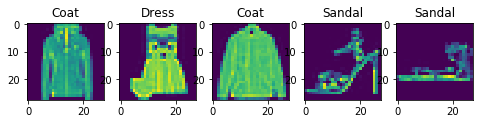

In [99]:
#Calling function with the test and training set, epochs =10 and default values lr=0.01, batch=32 and normalized (norm=True)
Predi = RLog(xtr=trimgs, xts=tsimgs, ytr=trlblso, yts=tslblso, epochs=5, pickindex=30, rand5=True)

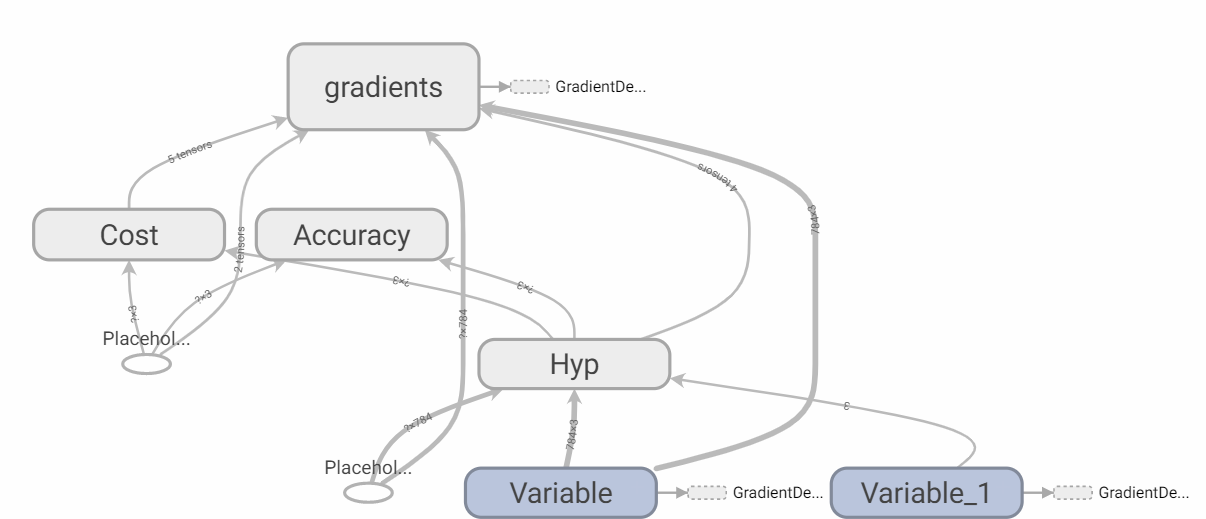


Grafo de Costo

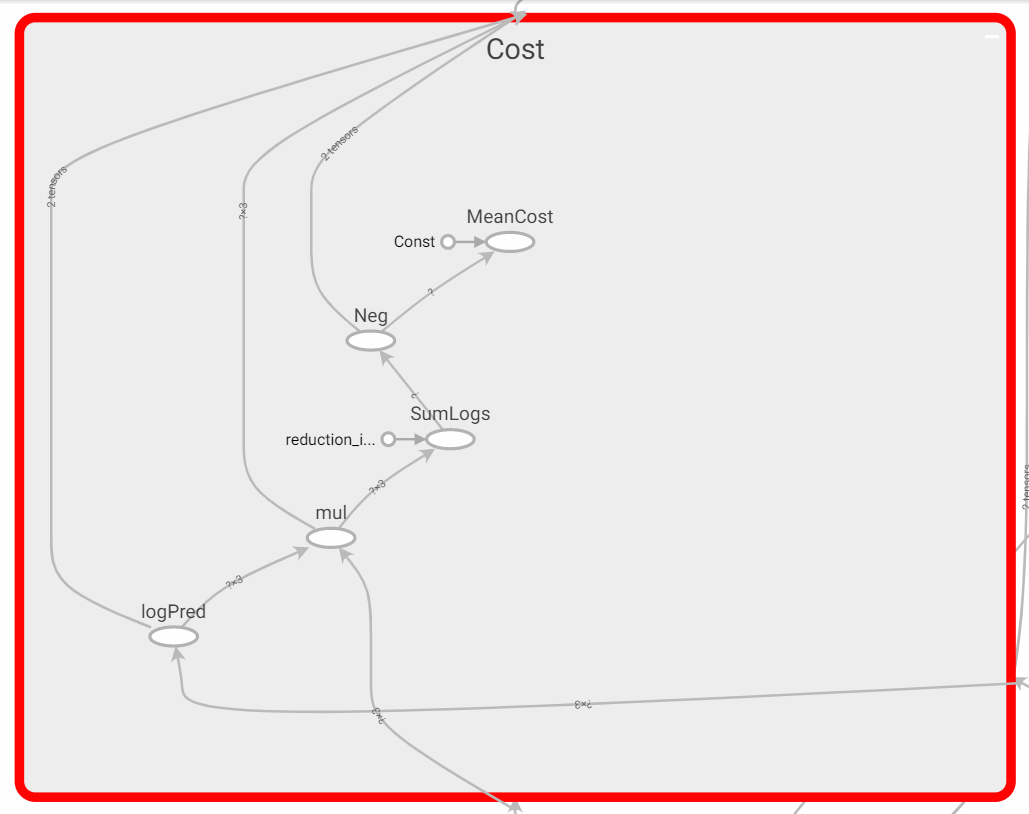

Grafo de Accuracy

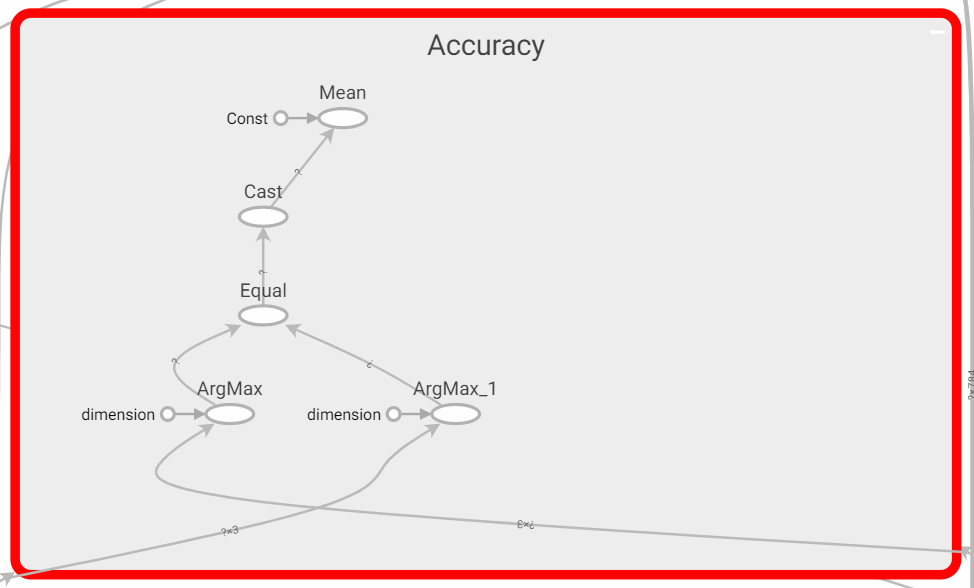